In [1]:
import tensorflow as tf
from tensorflow.keras import models, layers
import matplotlib.pyplot as plt

In [2]:
IMAGE_SIZE = 256
BATCH_SIZE = 32
CHANNELS = 3
EPOCHS = 50

In [3]:
dataset = tf.keras.preprocessing.image_dataset_from_directory(
            "data",
            shuffle=True,
            image_size=(IMAGE_SIZE, IMAGE_SIZE),
            batch_size=BATCH_SIZE,
        )

Found 2152 files belonging to 3 classes.


In [4]:
class_names = dataset.class_names
class_names

['Potato___Early_blight', 'Potato___Late_blight', 'Potato___healthy']

In [5]:
for image_batch, label_batch in dataset.take(1):
    print(image_batch.shape)
    print(label_batch.numpy())

(32, 256, 256, 3)
[0 1 0 0 1 0 1 1 1 1 1 1 1 2 2 1 0 0 0 0 0 1 1 0 1 0 2 0 0 1 1 1]


In [6]:
len(dataset) #total no. of batches

68

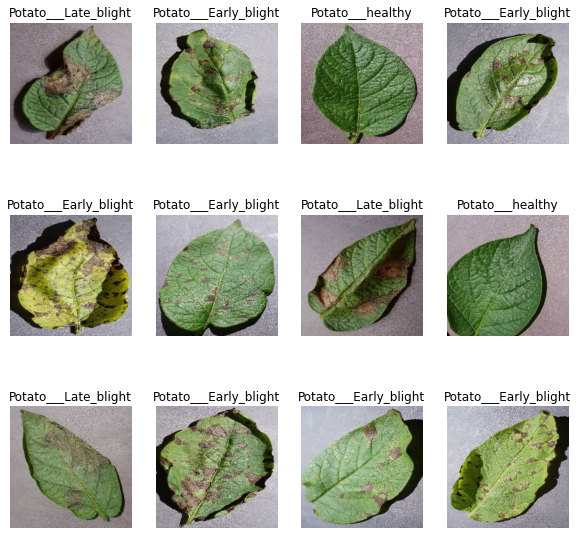

In [7]:
plt.figure(figsize=(10,10))
for image_batch, label_batch in dataset.take(1):
    for i in range(12):
        ax = plt.subplot(3, 4, i+1)
        plt.imshow(image_batch[i].numpy().astype("uint8"))
        plt.title(class_names[label_batch[i]])
        plt.axis("off")

In [8]:
def get_dataset_partition_tf(dataset, train_split=0.8, val_split=0.1, test_split=0.1, shuffle=True, shuffle_size=10000,):
    ds_size = len(dataset)
    
    if shuffle:
        dataset = dataset.shuffle(shuffle_size, seed=12)
    
    train_size = int(train_split*ds_size)
    val_size = int(val_split*ds_size)
    
    train_set = dataset.take(train_size)
    val_set = dataset.skip(train_size).take(val_size)
    test_set = dataset.skip(train_size).skip(val_size)
    
    return train_set, val_set, test_set

In [9]:
train_set, val_set, test_set = get_dataset_partition_tf(dataset)

In [10]:
train_set = train_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
val_set = val_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)
test_set = test_set.cache().shuffle(1000).prefetch(buffer_size=tf.data.AUTOTUNE)

In [11]:
resize_and_rescale = tf.keras.Sequential([
    layers.experimental.preprocessing.Resizing(IMAGE_SIZE, IMAGE_SIZE),
    layers.experimental.preprocessing.Rescaling(1.0/255),
])

In [12]:
data_augmentation = tf.keras.Sequential([
    layers.experimental.preprocessing.RandomFlip("horizontal_and_vertical"),
    layers.experimental.preprocessing.RandomRotation(0.2),
])

In [13]:
input_shape = (BATCH_SIZE, IMAGE_SIZE, IMAGE_SIZE, CHANNELS)
n_classes = 3

model = models.Sequential([
    resize_and_rescale,
    data_augmentation,
    layers.Conv2D(32, (3,3), activation='relu', input_shape=input_shape),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Conv2D(64, (3,3), activation='relu'),
    layers.MaxPooling2D((2,2)),
    layers.Flatten(),
    layers.Dense(64, activation='relu'),
    layers.Dense(n_classes, activation = 'softmax'),
])

model.build(input_shape=input_shape)

In [14]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 sequential (Sequential)     (32, 256, 256, 3)         0         
                                                                 
 sequential_1 (Sequential)   (32, 256, 256, 3)         0         
                                                                 
 conv2d (Conv2D)             (32, 254, 254, 32)        896       
                                                                 
 max_pooling2d (MaxPooling2D  (32, 127, 127, 32)       0         
 )                                                               
                                                                 
 conv2d_1 (Conv2D)           (32, 125, 125, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (32, 62, 62, 64)         0         
 2D)                                                  

In [15]:
model.compile(
    optimizer='adam',
    loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=False),
    metrics=['accuracy'],
)

In [16]:
hstory = model.fit(
                train_set,
                validation_data=val_set,
                epochs=EPOCHS,
                batch_size= BATCH_SIZE,
                verbose = 1,
)

Epoch 1/50
54/54 [==============================] - 126s 2s/step - loss: 0.9076 - accuracy: 0.4809 - val_loss: 0.8422 - val_accuracy: 0.4948
Epoch 2/50
54/54 [==============================] - 79s 1s/step - loss: 0.6834 - accuracy: 0.7031 - val_loss: 0.5434 - val_accuracy: 0.8125
Epoch 3/50
54/54 [==============================] - 74s 1s/step - loss: 0.4478 - accuracy: 0.8038 - val_loss: 0.3409 - val_accuracy: 0.9062
Epoch 4/50
54/54 [==============================] - 74s 1s/step - loss: 0.2751 - accuracy: 0.8993 - val_loss: 0.2356 - val_accuracy: 0.8750
Epoch 5/50
54/54 [==============================] - 75s 1s/step - loss: 0.2138 - accuracy: 0.9109 - val_loss: 0.1907 - val_accuracy: 0.9219
Epoch 6/50
54/54 [==============================] - 89s 2s/step - loss: 0.1668 - accuracy: 0.9369 - val_loss: 0.2387 - val_accuracy: 0.9323
Epoch 7/50
54/54 [==============================] - 80s 1s/step - loss: 0.1837 - accuracy: 0.9242 - val_loss: 0.1323 - val_accuracy: 0.9479
Epoch 8/50
54/54 [=

In [17]:
scores = model.evaluate(test_set)

8/8 [==============================] - 25s 521ms/step - loss: 0.0068 - accuracy: 0.9961


In [18]:
scores

[0.006790998857468367, 0.99609375]

In [23]:
hstory

In [24]:
hstory.params

{'verbose': 1, 'epochs': 50, 'steps': 54}

In [25]:
hstory.history.keys()

dict_keys(['loss', 'accuracy', 'val_loss', 'val_accuracy'])

In [26]:
acc = hstory.history["accuracy"]
val_acc = hstory.history["val_accuracy"]

loss = hstory.history["loss"]
val_loss = hstory.history["val_loss"]

Text(0.5, 1.0, 'Training & Validation Loss')

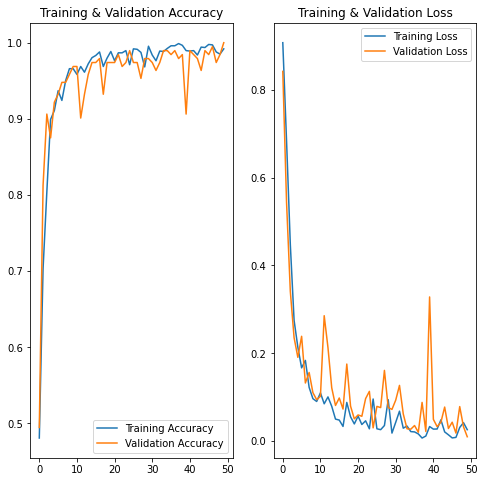

In [29]:
plt.figure(figsize=(8,8))

plt.subplot(1, 2, 1)
plt.plot(range(EPOCHS), acc, label="Training Accuracy")
plt.plot(range(EPOCHS), val_acc, label="Validation Accuracy")
plt.legend(loc='lower right')
plt.title('Training & Validation Accuracy')

plt.subplot(1, 2, 2)
plt.plot(range(EPOCHS), loss, label="Training Loss")
plt.plot(range(EPOCHS), val_loss, label="Validation Loss")
plt.legend(loc='upper right')
plt.title('Training & Validation Loss')

first image to predict
actual label:  Potato___Late_blight
predicted label:  Potato___Late_blight


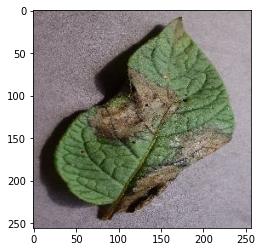

In [33]:
import numpy as np
for images_batch, labels_batch in test_set.take(1):
    
    first_image = image_batch[0].numpy().astype('uint8')
    first_label = labels_batch[0].numpy()
    
    print("first image to predict")
    plt.imshow(first_image)
    print("actual label: ", class_names[first_label])
    
    batch_prediction = model.predict(images_batch)
    print("predicted label: ", class_names[np.argmax(batch_prediction[0])])

In [34]:
def predict(model, img):
    img_array = tf.keras.preprocessing.image.img_to_array(images[i].numpy())
    img_array = tf.expand_dims(img_array, 0) # Create a batch
    predictions = model.predict(img_array)
    predicted_class = class_names[np.argmax(predictions[0])]
    confidence = round(100 * (np.max(predictions[0])), 2)
    return predicted_class, confidence

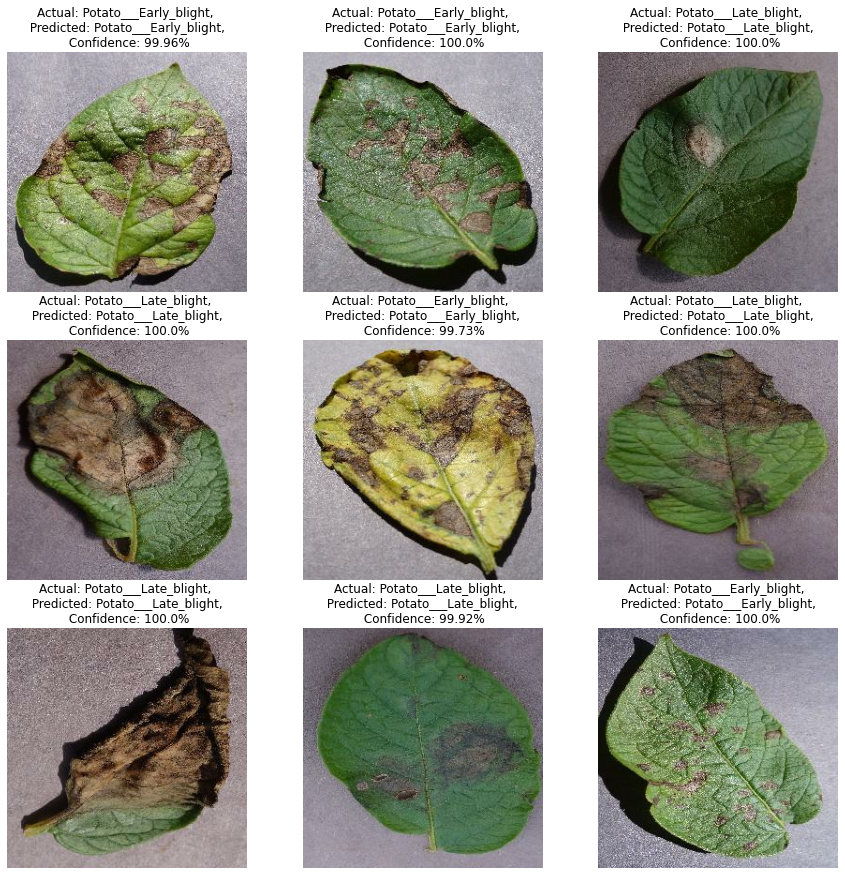

In [35]:
plt.figure(figsize=(15,15))
for images, labels in test_set.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i+1)
        plt.imshow(images[i].numpy().astype("uint8"))
        predicted_class, confidence = predict(model, images[i].numpy())
        actual_class = class_names[labels[i]]
        plt.title(f"Actual: {actual_class}, \n Predicted: {predicted_class}, \n Confidence: {confidence}%")
        plt.axis("off")

In [44]:
import os
model_version = max([int(i) for i in os.listdir("models") + [0]])+1
model.save(f"models/{model_version}")

INFO:tensorflow:Assets written to: models/3\assets
